In [1]:
import numpy as np
import pandas as pd

# Hyperparameter tuning results

In [2]:
def remove_underscore_after(val): # Remove underscore, and keep the part after the underscore
    return val.split('_')[-1]
def remove_underscore_before(val): # Remove underscore, and keep the part before the underscore
    return val.split('_')[0]
def map2d(func, grid): # Mapping for 2d arrays, from: https://stackoverflow.com/questions/70742445/elegant-map-over-2d-list
    return [[func(value) for value in row] for row in grid]
def full_display(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(df)
def prep_and_store_results(txt_path: str): # Prepare the (text-file) results to be stored in a csv
    with open(txt_path, 'r') as f:
        results = f.readlines()

    # Remove any non-result lines from the eval file, and split the lines on the tab character
    # (results have format: model_name\tdataset_name\tmetric_name\tmetric_value)
    results = [r.replace('\n','').split('\t') for r in results if '\t' in r]

    # Make a dataframe from the results
    df = pd.DataFrame(results, columns = ['model', 'dataset', 'metric', 'value'])
    df['value'] = pd.to_numeric(df['value'])
    # Remove the timestamp from the model names
    df['model'] = df['model'].map(lambda x: '-'.join(x.split('-')[2:]))

    # Make a list of model names, split by parameters - model names look like var1_xxx-var2_yyy-var3_zzz-... so split on '-'
    models = df['model'].str.split('-').tolist()
    
    # Remove all underscores from our 2d list, keep one list of the param names and one with param vals
    model_names_list = map2d(remove_underscore_before, models) # Keep the part before the underscore, aka the variable name
    model_names = np.array(model_names_list)
    model_val_list = map2d(remove_underscore_after, models) # Keep the part after the underscore, aka the variable's value
    model_vals = np.array(model_val_list)
    
    print('Number of evaluations:', model_vals.shape[0])

    # Splitting model name into columns, using the list of variables and their values
    for i in range(model_names.shape[-1]):
        name = model_names[0][i]
        val = model_vals[:,i]
        df[name] = val
        try: # Try to make columns numeric if possible
           df[name] = pd.to_numeric(df[name]) 
        except:
            pass
    
    # Remove columns that aren't used
    df = df.drop(['vit', 'model', 'data', 'ALL',  'kw'], axis = 1) #'method', 'AL.iter', 'ratio', 'PL',
    if 'fold' in df.columns.tolist():
        df = df.drop(['fold'], axis = 1)
    
    # Replace 'None' with NaN, to allow conversion to numerical
    df['AL.iter'] = df['AL.iter'].replace('None', np.nan)
    df['AL.iter'] = pd.to_numeric(df['AL.iter'])
    df['AL.epochs'] = df['AL.epochs'].replace('None', np.nan)
    df['AL.epochs'] = pd.to_numeric(df['AL.epochs'])

    cols = sorted(df.columns.tolist()) # Get a list of the columns of the dataframe
    print('Column names:', cols)

    display(df)

    # Group by all columns except the performance values, then compute mean, std and number of model runs for the performance
    df_grouped = df.groupby(list(set(cols)-set(['value'])), dropna = False).agg({'value':['mean', 'std', 'count']})

    df_grouped.to_csv(txt_path.replace('.txt', '.csv'))
    display(df_grouped)
    return df_grouped

def get_results_per_model(df, hyperparam_tuning = True):
    if hyperparam_tuning: # Only report on the results for a specific label ratio if we're hyperparam tuning
        df = df[(df['ratio'] == 0.1)]
    df_baseline = df[(df['AL.iter'].isna()) & (df['method'] == 'base')]
    df_S_CLIP = df[(df['AL.iter'].isna()) & (df['method'] == 'ours') & (df['PL'].str.contains('ot.'))]
    df_soft_PL = df[(df['AL.iter'].isna()) & (df['method'] == 'ours') & (df['PL'].str.contains('soft.'))]
    df_hard_PL = df[(df['AL.iter'].isna()) & (df['method'] == 'ours') & (df['PL'].str.contains('hard.'))]
    df_basic_AL = df[(df['AL.iter']>0) & (df['epochs']==15)]
    return { # return a dictionary of results per model
        'baseline': df_baseline, 's-clip': df_S_CLIP, 'soft-pl': df_soft_PL, 'hard-pl': df_hard_PL, 'basic-al': df_basic_AL, 'probvlm': None,
    }
    

In [3]:
validation_path = './eval.txt'
df_grouped = prep_and_store_results(validation_path)

Number of evaluations: 50310
Column names: ['AL.epochs', 'AL.iter', 'PL', 'bs', 'dataset', 'epochs', 'lr', 'method', 'metric', 'ratio', 'value']


,dataset,metric,value,ratio,method,AL.iter,AL.epochs,PL,epochs,lr,bs
0,RSICD-CLS,zeroshot-val-top1,60.99,0.1,base,NaN,NaN,None,5,0.000050,64
1,UCM-CLS,zeroshot-val-top1,56.84,0.1,base,NaN,NaN,None,5,0.000050,64
2,RSICD,image_to_text_R@1,4.76,0.1,base,NaN,NaN,None,5,0.000050,64
3,RSICD,image_to_text_R@5,20.05,0.1,base,NaN,NaN,None,5,0.000050,64
4,RSICD,image_to_text_R@10,33.88,0.1,base,NaN,NaN,None,5,0.000050,64
...,...,...,...,...,...,...,...,...,...,...,...
50305,Sydney,image_to_text_R@5,11.27,0.1,ours,NaN,NaN,hard.text,35,0.000005,128
50306,Sydney,image_to_text_R@10,19.52,0.1,ours,NaN,NaN,hard.text,35,0.000005,128
50307,Sydney,text_to_image_R@1,4.43,0.1,ours,NaN,NaN,hard.text,35,0.000005,128
50308,Sydney,text_to_image_R@5,10.66,0.1,ours,NaN,NaN,hard.text,35,0.000005,128


value  \
                                                                                               mean   
AL.epochs metric             method epochs PL        lr      AL.iter dataset   bs  ratio              
1.0       image_to_text_R@1  base   1      None      0.00001 3.0     RSICD     64  0.1     1.100000   
                                                                     Sydney    64  0.1     1.210000   
                                                                     UCM       64  0.1     3.850000   
          image_to_text_R@10 base   1      None      0.00001 3.0     RSICD     64  0.1     6.320000   
                                                                     Sydney    64  0.1    10.460000   
...                                                                                             ...   
NaN       zeroshot-val-top1  ours   35     soft.text 0.00005 NaN     UCM-CLS   128 0.1    68.810000   
                                                     0.00050 NaN     RSICD-CLS 64  0.1     2.815000   
                                                                               128 0.1     3.521111   
                                                                     UCM-CLS   64  0.1     4.812500   
                                                                               128 0.1     4.808889   

                                                                                                    \
                                                                                               std   
AL.epochs metric             method epochs PL        lr      AL.iter dataset   bs  ratio             
1.0       image_to_text_R@1  base   1      None      0.00001 3.0     RSICD     64  0.1         NaN   
                                                                     Sydney    64  0.1         NaN   
                                                                     UCM       64  0.1         NaN   
          image_to_text_R@10 base   1      None      0.00001 3.0     RSICD     64  0.1         NaN   
                                                                     Sydney    64  0.1         NaN   
...                                                                                            ...   
NaN       zeroshot-val-top1  ours   35     soft.text 0.00005 NaN     UCM-CLS   128 0.1    3.476025   
                                                     0.00050 NaN     RSICD-CLS 64  0.1    0.660126   
                                                                               128 0.1    0.348154   
                                                                     UCM-CLS   64  0.1    0.211877   
                                                                               128 0.1    0.187979   

                                                                                                
                                                                                         count  
AL.epochs metric             method epochs PL        lr      AL.iter dataset   bs  ratio        
1.0       image_to_text_R@1  base   1      None      0.00001 3.0     RSICD     64  0.1       1  
                                                                     Sydney    64  0.1       1  
                                                                     UCM       64  0.1       1  
          image_to_text_R@10 base   1      None      0.00001 3.0     RSICD     64  0.1       1  
                                                                     Sydney    64  0.1       1  
...                                                                                        ...  
NaN       zeroshot-val-top1  ours   35     soft.text 0.00005 NaN     UCM-CLS   128 0.1       9  
                                                     0.00050 NaN     RSICD-CLS 64  0.1       4  
                                                                               128 0.1       9  
                                                          

In [4]:
df_results = df_grouped.reset_index()
df_results['AL.epochs'] = df_results['AL.epochs'].fillna(df_results['epochs'])
df_results = df_results.sort_values(['metric', 'dataset', ('value', 'mean')])
display(df_results)

AL.epochs             metric method epochs         PL       lr AL.iter  \
                                                                              
609        5.0  image_to_text_R@1   ours      5  soft.text  0.00050     NaN   
1149      30.0  image_to_text_R@1   ours     30  soft.text  0.00050     NaN   
555        5.0  image_to_text_R@1   ours      5   ot.image  0.00050     NaN   
1186      35.0  image_to_text_R@1   ours     35  hard.text  0.00050     NaN   
556        5.0  image_to_text_R@1   ours      5   ot.image  0.00050     NaN   
...        ...                ...    ...    ...        ...      ...     ...   
6097       5.0  zeroshot-val-top1   base      5       None  0.00005     NaN   
6152      15.0  zeroshot-val-top1   base     15       None  0.00005     NaN   
6098       5.0  zeroshot-val-top1   base      5       None  0.00005     NaN   
6151      15.0  zeroshot-val-top1   base     15       None  0.00005     NaN   
6120      10.0  zeroshot-val-top1   base     10       None  0.00005     NaN   

      dataset   bs ratio    value                  
                             mean       std count  
609     RSICD   64   0.1   0.0675  0.045000     4  
1149    RSICD   64   0.1   0.0675  0.045000     4  
555     RSICD   64   0.1   0.0700  0.060000     9  
1186    RSICD  128   0.1   0.0700  0.039686     9  
556     RSICD  128   0.1   0.0800  0.030000     9  
...       ...  ...   ...      ...       ...   ...  
6097  UCM-CLS   64   0.5  77.7550  3.436680     4  
6152  UCM-CLS   64   0.7  77.9725  3.209884     4  
6098  UCM-CLS   64   0.7  78.1875  5.256433     4  
6151  UCM-CLS   64   0.5  78.2875  3.939225     4  
6120  UCM-CLS   64   0.7  78.3975  3.115032     4  

[6720 rows x 13 columns]

In [5]:
# Get the results, split per model (e.g. get results of baseline, s-clip, etc.)
results_dict = get_results_per_model(df_results)
df_baseline = results_dict['baseline']
df_basic_AL = results_dict['basic-al']
df_S_CLIP = results_dict['s-clip']
df_soft_PL = results_dict['soft-pl']
df_hard_PL = results_dict['hard-pl']

In [6]:
# Results with basic active learning
full_display(df_basic_AL.groupby(['metric', 'dataset']).tail(3)) #

AL.epochs              metric method epochs    PL       lr AL.iter  \
                                                                          
390       15.0   image_to_text_R@1   base     15  None  0.00005     1.0   
396       15.0   image_to_text_R@1   base     15  None  0.00005     5.0   
393       15.0   image_to_text_R@1   base     15  None  0.00005     3.0   
224       15.0   image_to_text_R@1   base     15  None  0.00005     3.0   
397       15.0   image_to_text_R@1   base     15  None  0.00005     5.0   
391       15.0   image_to_text_R@1   base     15  None  0.00005     1.0   
395       15.0   image_to_text_R@1   base     15  None  0.00005     3.0   
398       15.0   image_to_text_R@1   base     15  None  0.00005     5.0   
228       15.0   image_to_text_R@1   base     15  None  0.00005     3.0   
232       15.0  image_to_text_R@10   base     15  None  0.00005     3.0   
1356      15.0  image_to_text_R@10   base     15  None  0.00005     3.0   
1359      15.0  image_to_text_R@10   base     15  None  0.00005     5.0   
236       15.0  image_to_text_R@10   base     15  None  0.00005     3.0   
1360      15.0  image_to_text_R@10   base     15  None  0.00005     5.0   
1354      15.0  image_to_text_R@10   base     15  None  0.00005     1.0   
1358      15.0  image_to_text_R@10   base     15  None  0.00005     3.0   
240       15.0  image_to_text_R@10   base     15  None  0.00005     3.0   
1361      15.0  image_to_text_R@10   base     15  None  0.00005     5.0   
244       15.0   image_to_text_R@5   base     15  None  0.00005     3.0   
2322      15.0   image_to_text_R@5   base     15  None  0.00005     5.0   
2319      15.0   image_to_text_R@5   base     15  None  0.00005     3.0   
248       15.0   image_to_text_R@5   base     15  None  0.00005     3.0   
2323      15.0   image_to_text_R@5   base     15  None  0.00005     5.0   
2317      15.0   image_to_text_R@5   base     15  None  0.00005     1.0   
2321      15.0   image_to_text_R@5   base     15  None  0.00005     3.0   
2324      15.0   image_to_text_R@5   base     15  None  0.00005     5.0   
252       15.0   image_to_text_R@5   base     15  None  0.00005     3.0   
256       15.0   text_to_image_R@1   base     15  None  0.00005     3.0   
3282      15.0   text_to_image_R@1   base     15  None  0.00005     3.0   
3285      15.0   text_to_image_R@1   base     15  None  0.00005     5.0   
260       15.0   text_to_image_R@1   base     15  None  0.00005     3.0   
3280      15.0   text_to_image_R@1   base     15  None  0.00005     1.0   
3286      15.0   text_to_image_R@1   base     15  None  0.00005     5.0   
3284      15.0   text_to_image_R@1   base     15  None  0.00005     3.0   
264       15.0   text_to_image_R@1   base     15  None  0.00005     3.0   
3287      15.0   text_to_image_R@1   base     15  None  0.00005     5.0   
268       15.0  text_to_image_R@10   base     15  None  0.00005     3.0   
4245      15.0  text_to_image_R@10   base     15  None  0.00005     3.0   
4248      15.0  text_to_image_R@10   base     15  None  0.00005     5.0   
4246      15.0  text_to_image_R@10   base     15  None  0.00005     3.0   
4243      15.0  text_to_image_R@10   base     15  None  0.00005     1.0   
4249      15.0  text_to_image_R@10   base     15  None  0.00005     5.0   
4247      15.0  text_to_image_R@10   base     15  None  0.00005     3.0   
276       15.0  text_to_image_R@10   base     15  None  0.00005     3.0   
4250      15.0  text_to_image_R@10   base     15  None  0.00005     5.0   
280       15.0   text_to_image_R@5   base     15  None  0.00005     3.0   
5208      15.0   text_to_image_R@5   base     15  None  0.00005     3.0   
5211      15.0   text_to_image_R@5   base     15  None  0.00005     5.0   
5209      15.0   text_to_image_R@5   base     15  None  0.00005     3.0   
5206      15.0   text_to_image_R@5   base     15  None  0.00005     1.0   
5212      15.0   text_to_image_R@5   base     15  None  0.00005     5.0   
5210      15.0   text_to_image

In [7]:
full_display(df_baseline.groupby(['metric', 'dataset']).tail(3))

AL.epochs              metric method epochs    PL       lr AL.iter  \
                                                                          
459       25.0   image_to_text_R@1   base     25  None  0.00005     NaN   
495       35.0   image_to_text_R@1   base     35  None  0.00005     NaN   
477       30.0   image_to_text_R@1   base     30  None  0.00005     NaN   
479       30.0   image_to_text_R@1   base     30  None  0.00005     NaN   
480       30.0   image_to_text_R@1   base     30  None  0.00005     NaN   
498       35.0   image_to_text_R@1   base     35  None  0.00005     NaN   
499       35.0   image_to_text_R@1   base     35  None  0.00005     NaN   
464       25.0   image_to_text_R@1   base     25  None  0.00005     NaN   
481       30.0   image_to_text_R@1   base     30  None  0.00005     NaN   
1440      30.0  image_to_text_R@10   base     30  None  0.00005     NaN   
1422      25.0  image_to_text_R@10   base     25  None  0.00005     NaN   
1458      35.0  image_to_text_R@10   base     35  None  0.00005     NaN   
1443      30.0  image_to_text_R@10   base     30  None  0.00005     NaN   
1442      30.0  image_to_text_R@10   base     30  None  0.00005     NaN   
1460      35.0  image_to_text_R@10   base     35  None  0.00005     NaN   
1462      35.0  image_to_text_R@10   base     35  None  0.00005     NaN   
1463      35.0  image_to_text_R@10   base     35  None  0.00005     NaN   
1445      30.0  image_to_text_R@10   base     30  None  0.00005     NaN   
2385      25.0   image_to_text_R@5   base     25  None  0.00005     NaN   
2403      30.0   image_to_text_R@5   base     30  None  0.00005     NaN   
2421      35.0   image_to_text_R@5   base     35  None  0.00005     NaN   
2405      30.0   image_to_text_R@5   base     30  None  0.00005     NaN   
2406      30.0   image_to_text_R@5   base     30  None  0.00005     NaN   
2424      35.0   image_to_text_R@5   base     35  None  0.00005     NaN   
2426      35.0   image_to_text_R@5   base     35  None  0.00005     NaN   
2425      35.0   image_to_text_R@5   base     35  None  0.00005     NaN   
2408      30.0   image_to_text_R@5   base     30  None  0.00005     NaN   
3348      25.0   text_to_image_R@1   base     25  None  0.00005     NaN   
3366      30.0   text_to_image_R@1   base     30  None  0.00005     NaN   
3384      35.0   text_to_image_R@1   base     35  None  0.00005     NaN   
3351      25.0   text_to_image_R@1   base     25  None  0.00005     NaN   
3369      30.0   text_to_image_R@1   base     30  None  0.00005     NaN   
3387      35.0   text_to_image_R@1   base     35  None  0.00005     NaN   
3370      30.0   text_to_image_R@1   base     30  None  0.00005     NaN   
3371      30.0   text_to_image_R@1   base     30  None  0.00005     NaN   
3389      35.0   text_to_image_R@1   base     35  None  0.00005     NaN   
4311      25.0  text_to_image_R@10   base     25  None  0.00005     NaN   
4347      35.0  text_to_image_R@10   base     35  None  0.00005     NaN   
4329      30.0  text_to_image_R@10   base     30  None  0.00005     NaN   
4350      35.0  text_to_image_R@10   base     35  None  0.00005     NaN   
4349      35.0  text_to_image_R@10   base     35  None  0.00005     NaN   
4331      30.0  text_to_image_R@10   base     30  None  0.00005     NaN   
4352      35.0  text_to_image_R@10   base     35  None  0.00005     NaN   
4333      30.0  text_to_image_R@10   base     30  None  0.00005     NaN   
4351      35.0  text_to_image_R@10   base     35  None  0.00005     NaN   
5274      25.0   text_to_image_R@5   base     25  None  0.00005     NaN   
5310      35.0   text_to_image_R@5   base     35  None  0.00005     NaN   
5292      30.0   text_to_image_R@5   base     30  None  0.00005     NaN   
5295      30.0   text_to_image_R@5   base     30  None  0.00005     NaN   
5312      35.0   text_to_image_R@5   base     35  None  0.00005     NaN   
5313      35.0   text_to_image_R@5   base     35  None  0.00005     NaN   
5314      35.0   text_to_image

In [8]:
full_display(df_S_CLIP.groupby(['metric', 'dataset']).tail(3))

AL.epochs              metric method epochs        PL       lr AL.iter  \
                                                                              
982       25.0   image_to_text_R@1   ours     25  ot.image  0.00005     NaN   
1090      30.0   image_to_text_R@1   ours     30  ot.image  0.00005     NaN   
1198      35.0   image_to_text_R@1   ours     35  ot.image  0.00005     NaN   
768       15.0   image_to_text_R@1   ours     15  ot.image  0.00005     NaN   
1092      30.0   image_to_text_R@1   ours     30  ot.image  0.00005     NaN   
1200      35.0   image_to_text_R@1   ours     35  ot.image  0.00005     NaN   
986       25.0   image_to_text_R@1   ours     25  ot.image  0.00005     NaN   
1094      30.0   image_to_text_R@1   ours     30  ot.image  0.00005     NaN   
1202      35.0   image_to_text_R@1   ours     35  ot.image  0.00005     NaN   
1945      25.0  image_to_text_R@10   ours     25  ot.image  0.00005     NaN   
2161      35.0  image_to_text_R@10   ours     35  ot.image  0.00005     NaN   
2053      30.0  image_to_text_R@10   ours     30  ot.image  0.00005     NaN   
1947      25.0  image_to_text_R@10   ours     25  ot.image  0.00005     NaN   
2055      30.0  image_to_text_R@10   ours     30  ot.image  0.00005     NaN   
2163      35.0  image_to_text_R@10   ours     35  ot.image  0.00005     NaN   
2164      35.0  image_to_text_R@10   ours     35  ot.image  0.00005     NaN   
2057      30.0  image_to_text_R@10   ours     30  ot.image  0.00005     NaN   
2165      35.0  image_to_text_R@10   ours     35  ot.image  0.00005     NaN   
2908      25.0   image_to_text_R@5   ours     25  ot.image  0.00005     NaN   
3016      30.0   image_to_text_R@5   ours     30  ot.image  0.00005     NaN   
3124      35.0   image_to_text_R@5   ours     35  ot.image  0.00005     NaN   
3017      30.0   image_to_text_R@5   ours     30  ot.image  0.00005     NaN   
3018      30.0   image_to_text_R@5   ours     30  ot.image  0.00005     NaN   
3126      35.0   image_to_text_R@5   ours     35  ot.image  0.00005     NaN   
3128      35.0   image_to_text_R@5   ours     35  ot.image  0.00005     NaN   
3020      30.0   image_to_text_R@5   ours     30  ot.image  0.00005     NaN   
2912      25.0   image_to_text_R@5   ours     25  ot.image  0.00005     NaN   
3979      30.0   text_to_image_R@1   ours     30  ot.image  0.00005     NaN   
4087      35.0   text_to_image_R@1   ours     35  ot.image  0.00005     NaN   
4086      35.0   text_to_image_R@1   ours     35  ot.image  0.00005     NaN   
4089      35.0   text_to_image_R@1   ours     35  ot.image  0.00005     NaN   
3981      30.0   text_to_image_R@1   ours     30  ot.image  0.00005     NaN   
3873      25.0   text_to_image_R@1   ours     25  ot.image  0.00005     NaN   
3875      25.0   text_to_image_R@1   ours     25  ot.image  0.00005     NaN   
3983      30.0   text_to_image_R@1   ours     30  ot.image  0.00005     NaN   
4091      35.0   text_to_image_R@1   ours     35  ot.image  0.00005     NaN   
4834      25.0  text_to_image_R@10   ours     25  ot.image  0.00005     NaN   
4942      30.0  text_to_image_R@10   ours     30  ot.image  0.00005     NaN   
5050      35.0  text_to_image_R@10   ours     35  ot.image  0.00005     NaN   
4836      25.0  text_to_image_R@10   ours     25  ot.image  0.00005     NaN   
4944      30.0  text_to_image_R@10   ours     30  ot.image  0.00005     NaN   
5052      35.0  text_to_image_R@10   ours     35  ot.image  0.00005     NaN   
4946      30.0  text_to_image_R@10   ours     30  ot.image  0.00005     NaN   
5053      35.0  text_to_image_R@10   ours     35  ot.image  0.00005     NaN   
5054      35.0  text_to_image_R@10   ours     35  ot.image  0.00005     NaN   
5797      25.0   text_to_image_R@5   ours     25  ot.image  0.00005     NaN   
6013      35.0   text_to_image_R@5   ours     35  ot.image  0.00005     NaN   
5905      30.0   text_to_image_R@5   ours     30  ot.image  0.00005     NaN   
5799      25.0   text_to_image_R@5   ours     25  ot.im

In [9]:
full_display(df_soft_PL.groupby(['metric', 'dataset']).tail(3))

AL.epochs              metric method epochs          PL       lr AL.iter  \
                                                                                
1143      30.0   image_to_text_R@1   ours     30   soft.text  0.00005     NaN   
1126      30.0   image_to_text_R@1   ours     30  soft.image  0.00005     NaN   
1251      35.0   image_to_text_R@1   ours     35   soft.text  0.00005     NaN   
1128      30.0   image_to_text_R@1   ours     30  soft.image  0.00005     NaN   
1253      35.0   image_to_text_R@1   ours     35   soft.text  0.00005     NaN   
1236      35.0   image_to_text_R@1   ours     35  soft.image  0.00005     NaN   
1148      30.0   image_to_text_R@1   ours     30   soft.text  0.00005     NaN   
1255      35.0   image_to_text_R@1   ours     35   soft.text  0.00005     NaN   
1256      35.0   image_to_text_R@1   ours     35   soft.text  0.00005     NaN   
2215      35.0  image_to_text_R@10   ours     35   soft.text  0.00005     NaN   
2214      35.0  image_to_text_R@10   ours     35   soft.text  0.00005     NaN   
2106      30.0  image_to_text_R@10   ours     30   soft.text  0.00005     NaN   
2000      25.0  image_to_text_R@10   ours     25   soft.text  0.00005     NaN   
2109      30.0  image_to_text_R@10   ours     30   soft.text  0.00005     NaN   
2217      35.0  image_to_text_R@10   ours     35   soft.text  0.00005     NaN   
1985      25.0  image_to_text_R@10   ours     25  soft.image  0.00005     NaN   
2218      35.0  image_to_text_R@10   ours     35   soft.text  0.00005     NaN   
2110      30.0  image_to_text_R@10   ours     30   soft.text  0.00005     NaN   
3178      35.0   image_to_text_R@5   ours     35   soft.text  0.00005     NaN   
3069      30.0   image_to_text_R@5   ours     30   soft.text  0.00005     NaN   
3177      35.0   image_to_text_R@5   ours     35   soft.text  0.00005     NaN   
3162      35.0   image_to_text_R@5   ours     35  soft.image  0.00005     NaN   
3072      30.0   image_to_text_R@5   ours     30   soft.text  0.00005     NaN   
3180      35.0   image_to_text_R@5   ours     35   soft.text  0.00005     NaN   
3074      30.0   image_to_text_R@5   ours     30   soft.text  0.00005     NaN   
3073      30.0   image_to_text_R@5   ours     30   soft.text  0.00005     NaN   
3181      35.0   image_to_text_R@5   ours     35   soft.text  0.00005     NaN   
4141      35.0   text_to_image_R@1   ours     35   soft.text  0.00005     NaN   
4032      30.0   text_to_image_R@1   ours     30   soft.text  0.00005     NaN   
4033      30.0   text_to_image_R@1   ours     30   soft.text  0.00005     NaN   
3927      25.0   text_to_image_R@1   ours     25   soft.text  0.00005     NaN   
4017      30.0   text_to_image_R@1   ours     30  soft.image  0.00005     NaN   
4143      35.0   text_to_image_R@1   ours     35   soft.text  0.00005     NaN   
3911      25.0   text_to_image_R@1   ours     25  soft.image  0.00005     NaN   
4144      35.0   text_to_image_R@1   ours     35   soft.text  0.00005     NaN   
4127      35.0   text_to_image_R@1   ours     35  soft.image  0.00005     NaN   
5104      35.0  text_to_image_R@10   ours     35   soft.text  0.00005     NaN   
4995      30.0  text_to_image_R@10   ours     30   soft.text  0.00005     NaN   
5103      35.0  text_to_image_R@10   ours     35   soft.text  0.00005     NaN   
4998      30.0  text_to_image_R@10   ours     30   soft.text  0.00005     NaN   
5088      35.0  text_to_image_R@10   ours     35  soft.image  0.00005     NaN   
5106      35.0  text_to_image_R@10   ours     35   soft.text  0.00005     NaN   
4891      25.0  text_to_image_R@10   ours     25   soft.text  0.00005     NaN   
4999      30.0  text_to_image_R@10   ours     30   soft.text  0.00005     NaN   
5107      35.0  text_to_image_R@10   ours     35   soft.text  0.00005     NaN   
5959      30.0   text_to_image_R@5   ours     30   soft.text  0.00005     NaN   
5958      30.0   text_to_image_R@5   ours     30   soft.text  0.00005     NaN   
6066      35.0   text_to_image_R@5  

In [10]:
full_display(df_hard_PL.groupby(['metric', 'dataset']).tail(3))

AL.epochs              metric method epochs          PL       lr AL.iter  \
                                                                                
963       25.0   image_to_text_R@1   ours     25   hard.text  0.00005     NaN   
1180      35.0   image_to_text_R@1   ours     35   hard.text  0.00005     NaN   
1179      35.0   image_to_text_R@1   ours     35   hard.text  0.00005     NaN   
1163      35.0   image_to_text_R@1   ours     35  hard.image  0.00005     NaN   
1055      30.0   image_to_text_R@1   ours     30  hard.image  0.00005     NaN   
965       25.0   image_to_text_R@1   ours     25   hard.text  0.00005     NaN   
1057      30.0   image_to_text_R@1   ours     30  hard.image  0.00005     NaN   
1076      30.0   image_to_text_R@1   ours     30   hard.text  0.00005     NaN   
1184      35.0   image_to_text_R@1   ours     35   hard.text  0.00005     NaN   
2143      35.0  image_to_text_R@10   ours     35   hard.text  0.00005     NaN   
2034      30.0  image_to_text_R@10   ours     30   hard.text  0.00005     NaN   
2142      35.0  image_to_text_R@10   ours     35   hard.text  0.00005     NaN   
2145      35.0  image_to_text_R@10   ours     35   hard.text  0.00005     NaN   
2036      30.0  image_to_text_R@10   ours     30   hard.text  0.00005     NaN   
2144      35.0  image_to_text_R@10   ours     35   hard.text  0.00005     NaN   
2020      30.0  image_to_text_R@10   ours     30  hard.image  0.00005     NaN   
2146      35.0  image_to_text_R@10   ours     35   hard.text  0.00005     NaN   
2038      30.0  image_to_text_R@10   ours     30   hard.text  0.00005     NaN   
3105      35.0   image_to_text_R@5   ours     35   hard.text  0.00005     NaN   
2889      25.0   image_to_text_R@5   ours     25   hard.text  0.00005     NaN   
2997      30.0   image_to_text_R@5   ours     30   hard.text  0.00005     NaN   
2999      30.0   image_to_text_R@5   ours     30   hard.text  0.00005     NaN   
3108      35.0   image_to_text_R@5   ours     35   hard.text  0.00005     NaN   
2891      25.0   image_to_text_R@5   ours     25   hard.text  0.00005     NaN   
3110      35.0   image_to_text_R@5   ours     35   hard.text  0.00005     NaN   
3091      35.0   image_to_text_R@5   ours     35  hard.image  0.00005     NaN   
3002      30.0   image_to_text_R@5   ours     30   hard.text  0.00005     NaN   
3852      25.0   text_to_image_R@1   ours     25   hard.text  0.00005     NaN   
3960      30.0   text_to_image_R@1   ours     30   hard.text  0.00005     NaN   
4068      35.0   text_to_image_R@1   ours     35   hard.text  0.00005     NaN   
3855      25.0   text_to_image_R@1   ours     25   hard.text  0.00005     NaN   
4071      35.0   text_to_image_R@1   ours     35   hard.text  0.00005     NaN   
3963      30.0   text_to_image_R@1   ours     30   hard.text  0.00005     NaN   
3964      30.0   text_to_image_R@1   ours     30   hard.text  0.00005     NaN   
4073      35.0   text_to_image_R@1   ours     35   hard.text  0.00005     NaN   
4054      35.0   text_to_image_R@1   ours     35  hard.image  0.00005     NaN   
5032      35.0  text_to_image_R@10   ours     35   hard.text  0.00005     NaN   
4923      30.0  text_to_image_R@10   ours     30   hard.text  0.00005     NaN   
5031      35.0  text_to_image_R@10   ours     35   hard.text  0.00005     NaN   
4925      30.0  text_to_image_R@10   ours     30   hard.text  0.00005     NaN   
4926      30.0  text_to_image_R@10   ours     30   hard.text  0.00005     NaN   
5034      35.0  text_to_image_R@10   ours     35   hard.text  0.00005     NaN   
4927      30.0  text_to_image_R@10   ours     30   hard.text  0.00005     NaN   
4819      25.0  text_to_image_R@10   ours     25   hard.text  0.00005     NaN   
5035      35.0  text_to_image_R@10   ours     35   hard.text  0.00005     NaN   
5995      35.0   text_to_image_R@5   ours     35   hard.text  0.00005     NaN   
5886      30.0   text_to_image_R@5   ours     30   hard.text  0.00005     NaN   
5994      35.0   text_to_image_R@5  

# Test split evaluation results

In [11]:
test_path = './test_eval.txt'
df_grouped = prep_and_store_results(test_path)

Number of evaluations: 2808
Column names: ['AL.epochs', 'AL.iter', 'PL', 'bs', 'dataset', 'epochs', 'lr', 'method', 'metric', 'ratio', 'value']


,dataset,metric,value,ratio,method,AL.iter,AL.epochs,PL,epochs,lr,bs
0,RSICD-CLS,zeroshot-val-top1,48.58,0.05,base,NaN,NaN,None,5,0.00005,64
1,UCM-CLS,zeroshot-val-top1,46.19,0.05,base,NaN,NaN,None,5,0.00005,64
2,WHU-RS19,zeroshot-val-top1,71.94,0.05,base,NaN,NaN,None,5,0.00005,64
3,RSSCN7,zeroshot-val-top1,58.14,0.05,base,NaN,NaN,None,5,0.00005,64
4,AID,zeroshot-val-top1,52.05,0.05,base,NaN,NaN,None,5,0.00005,64
...,...,...,...,...,...,...,...,...,...,...,...
2803,Sydney,image_to_text_R@5,13.68,0.40,base,NaN,NaN,None,5,0.00005,64
2804,Sydney,image_to_text_R@10,22.33,0.40,base,NaN,NaN,None,5,0.00005,64
2805,Sydney,text_to_image_R@1,3.82,0.40,base,NaN,NaN,None,5,0.00005,64
2806,Sydney,text_to_image_R@5,15.09,0.40,base,NaN,NaN,None,5,0.00005,64


value  \
                                                                                    mean   
AL.epochs metric            method epochs PL   lr      AL.iter dataset  bs ratio           
NaN       image_to_text_R@1 base   1      None 0.00005 NaN     RSICD    64 0.40    4.670   
                                                               Sydney   64 0.40    2.820   
                                                               UCM      64 0.40    6.190   
                                   2      None 0.00005 NaN     RSICD    64 0.40    5.580   
                                                               Sydney   64 0.40    4.230   
...                                                                                  ...   
          zeroshot-val-top1 base   35     None 0.00005 NaN     UCM-CLS  64 0.40   73.810   
                                                               WHU-RS19 64 0.05   74.090   
                                                                           0.10   82.964   
                                                                           0.20   87.122   
                                                                           0.40   93.530   

                                                                                            \
                                                                                       std   
AL.epochs metric            method epochs PL   lr      AL.iter dataset  bs ratio             
NaN       image_to_text_R@1 base   1      None 0.00005 NaN     RSICD    64 0.40        NaN   
                                                               Sydney   64 0.40        NaN   
                                                               UCM      64 0.40        NaN   
                                   2      None 0.00005 NaN     RSICD    64 0.40        NaN   
                                                               Sydney   64 0.40        NaN   
...                                                                                    ...   
          zeroshot-val-top1 base   35     None 0.00005 NaN     UCM-CLS  64 0.40        NaN   
                                                               WHU-RS19 64 0.05   1.919792   
                                                                           0.10   1.125491   
                                                                           0.20   1.982365   
                                                                           0.40        NaN   

                                                                                        
                                                                                 count  
AL.epochs metric            method epochs PL   lr      AL.iter dataset  bs ratio        
NaN       image_to_text_R@1 base   1      None 0.00005 NaN     RSICD    64 0.40      1  
                                                               Sydney   64 0.40      1  
                                                               UCM      64 0.40      1  
                                   2      None 0.00005 NaN     RSICD    64 0.40      1  
                                                               Sydney   64 0.40      1  
...                                                                                ...  
          zeroshot-val-top1 base   35     None 0.00005 NaN     UCM-CLS  64 0.40      1  
                                                               WHU-RS19 64 0.05      5  
                                                                           0.10      5  
                                                                           0.20      5  
                                                                           0.40      1  

[768 rows x 3 columns]

In [12]:
df_results = df_grouped.reset_index()
df_results['AL.epochs'] = df_results['AL.epochs'].fillna(df_results['epochs'])
df_results = df_results.sort_values(['metric', 'dataset', ('value', 'mean')])
display(df_results)

AL.epochs             metric method epochs    PL       lr AL.iter  \
                                                                        
24       10.0  image_to_text_R@1   base     10  None  0.00005     NaN   
36       15.0  image_to_text_R@1   base     15  None  0.00005     NaN   
12        5.0  image_to_text_R@1   base      5  None  0.00005     NaN   
48       20.0  image_to_text_R@1   base     20  None  0.00005     NaN   
13        5.0  image_to_text_R@1   base      5  None  0.00005     NaN   
..        ...                ...    ...    ...   ...      ...     ...   
671      15.0  zeroshot-val-top1   base     15  None  0.00005     NaN   
743      30.0  zeroshot-val-top1   base     30  None  0.00005     NaN   
767      35.0  zeroshot-val-top1   base     35  None  0.00005     NaN   
695      20.0  zeroshot-val-top1   base     20  None  0.00005     NaN   
719      25.0  zeroshot-val-top1   base     25  None  0.00005     NaN   

      dataset  bs ratio   value                  
                           mean       std count  
24      RSICD  64  0.05   2.800  0.531084     5  
36      RSICD  64  0.05   2.982  0.371174     5  
12      RSICD  64  0.05   3.166  0.344572     5  
48      RSICD  64  0.05   3.366  0.387208     5  
13      RSICD  64  0.10   3.420  0.264670     5  
..        ...  ..   ...     ...       ...   ...  
671  WHU-RS19  64  0.40  93.030       NaN     1  
743  WHU-RS19  64  0.40  93.530       NaN     1  
767  WHU-RS19  64  0.40  93.530       NaN     1  
695  WHU-RS19  64  0.40  93.730       NaN     1  
719  WHU-RS19  64  0.40  93.730       NaN     1  

[768 rows x 13 columns]

In [13]:
# Get the results, split per model (e.g. get results of baseline, s-clip, etc.)
results_dict = get_results_per_model(df_results, False)
df_baseline = results_dict['baseline']
df_basic_AL = results_dict['basic-al']
df_S_CLIP = results_dict['s-clip']
df_soft_PL = results_dict['soft-pl']
df_hard_PL = results_dict['hard-pl']

In [14]:
df_baseline = df_baseline[(df_baseline['epochs']==25)&(df_baseline['bs']==64)&(df_baseline['lr']==5e-5)]
full_display(df_baseline) # .groupby(['metric', 'dataset'])

AL.epochs              metric method epochs    PL       lr AL.iter  \
                                                                         
60       25.0   image_to_text_R@1   base     25  None  0.00005     NaN   
61       25.0   image_to_text_R@1   base     25  None  0.00005     NaN   
62       25.0   image_to_text_R@1   base     25  None  0.00005     NaN   
63       25.0   image_to_text_R@1   base     25  None  0.00005     NaN   
64       25.0   image_to_text_R@1   base     25  None  0.00005     NaN   
65       25.0   image_to_text_R@1   base     25  None  0.00005     NaN   
66       25.0   image_to_text_R@1   base     25  None  0.00005     NaN   
67       25.0   image_to_text_R@1   base     25  None  0.00005     NaN   
68       25.0   image_to_text_R@1   base     25  None  0.00005     NaN   
69       25.0   image_to_text_R@1   base     25  None  0.00005     NaN   
71       25.0   image_to_text_R@1   base     25  None  0.00005     NaN   
70       25.0   image_to_text_R@1   base     25  None  0.00005     NaN   
156      25.0  image_to_text_R@10   base     25  None  0.00005     NaN   
157      25.0  image_to_text_R@10   base     25  None  0.00005     NaN   
158      25.0  image_to_text_R@10   base     25  None  0.00005     NaN   
159      25.0  image_to_text_R@10   base     25  None  0.00005     NaN   
160      25.0  image_to_text_R@10   base     25  None  0.00005     NaN   
161      25.0  image_to_text_R@10   base     25  None  0.00005     NaN   
162      25.0  image_to_text_R@10   base     25  None  0.00005     NaN   
163      25.0  image_to_text_R@10   base     25  None  0.00005     NaN   
164      25.0  image_to_text_R@10   base     25  None  0.00005     NaN   
165      25.0  image_to_text_R@10   base     25  None  0.00005     NaN   
166      25.0  image_to_text_R@10   base     25  None  0.00005     NaN   
167      25.0  image_to_text_R@10   base     25  None  0.00005     NaN   
252      25.0   image_to_text_R@5   base     25  None  0.00005     NaN   
253      25.0   image_to_text_R@5   base     25  None  0.00005     NaN   
254      25.0   image_to_text_R@5   base     25  None  0.00005     NaN   
255      25.0   image_to_text_R@5   base     25  None  0.00005     NaN   
256      25.0   image_to_text_R@5   base     25  None  0.00005     NaN   
257      25.0   image_to_text_R@5   base     25  None  0.00005     NaN   
258      25.0   image_to_text_R@5   base     25  None  0.00005     NaN   
259      25.0   image_to_text_R@5   base     25  None  0.00005     NaN   
260      25.0   image_to_text_R@5   base     25  None  0.00005     NaN   
261      25.0   image_to_text_R@5   base     25  None  0.00005     NaN   
262      25.0   image_to_text_R@5   base     25  None  0.00005     NaN   
263      25.0   image_to_text_R@5   base     25  None  0.00005     NaN   
348      25.0   text_to_image_R@1   base     25  None  0.00005     NaN   
349      25.0   text_to_image_R@1   base     25  None  0.00005     NaN   
350      25.0   text_to_image_R@1   base     25  None  0.00005     NaN   
351      25.0   text_to_image_R@1   base     25  None  0.00005     NaN   
352      25.0   text_to_image_R@1   base     25  None  0.00005     NaN   
353      25.0   text_to_image_R@1   base     25  None  0.00005     NaN   
354      25.0   text_to_image_R@1   base     25  None  0.00005     NaN   
355      25.0   text_to_image_R@1   base     25  None  0.00005     NaN   
356      25.0   text_to_image_R@1   base     25  None  0.00005     NaN   
357      25.0   text_to_image_R@1   base     25  None  0.00005     NaN   
359      25.0   text_to_image_R@1   base     25  None  0.00005     NaN   
358      25.0   text_to_image_R@1   base     25  None  0.00005     NaN   
444      25.0  text_to_image_R@10   base     25  None  0.00005     NaN   
445      25.0  text_to_image_R@10   base     25  None  0.00005     NaN   
446      25.0  text_to_image_R@10   base     25  None  0.00005     NaN   
447      25.0  text_to_image_R@10   base     25  None  0.00005     NaN   
448     

In [15]:
def performance_per_label_ratio(df, metric, dataset):
    df_filtered = df[(df['metric'] == metric) & (df['dataset'] == dataset)]
    # Ensure the order is from the smallest label ratio to the largest
    df_filtered = df_filtered.sort_values(by='ratio')
    display(df_filtered)
    # Get the performance mean for the metric
    performance = df_filtered[('value', 'mean')].to_numpy()
    label_ratios = df_filtered['ratio'].to_numpy()
    return performance, label_ratios

In [16]:
import matplotlib.pyplot as plt
def plot_model_comparison(results_dict, metric, dataset):
    epochs = {'baseline': 25, 'basic-al': 15, 's-clip': 25, 'soft-pl': 30, 'hard-pl': 25}
    # Get the performance of each model, for the given metric and dataset
    for model in results_dict:
        model_results = results_dict[model]
        # If we have any results for the given model, add it to the plot
        if model_results is not None and model_results.shape[0] > 0: 
            # Filter for correct number of epochs
            model_results = model_results[model_results['epochs'] == epochs[model]]
            performance, label_ratios = performance_per_label_ratio(model_results, metric, dataset)
            plt.plot(performance, label = model)
    # Add information about the dataset, metric and label ratios to the plot
    plt.title(f'{metric} (dataset: {dataset})')
    plt.xticks(np.arange(label_ratios.shape[0]), label_ratios)
    ylabel = 'recall' if 'R@' in metric else 'accuracy'
    plt.ylabel(ylabel)
    plt.xlabel('Label ratio')
    plt.legend()
    plt.show()


AL.epochs             metric method epochs    PL       lr AL.iter dataset  \
                                                                               
60      25.0  image_to_text_R@1   base     25  None  0.00005     NaN   RSICD   
61      25.0  image_to_text_R@1   base     25  None  0.00005     NaN   RSICD   
62      25.0  image_to_text_R@1   base     25  None  0.00005     NaN   RSICD   
63      25.0  image_to_text_R@1   base     25  None  0.00005     NaN   RSICD   

    bs ratio  value                  
               mean       std count  
60  64  0.05  3.624  0.425124     5  
61  64  0.10  4.284  0.556040     5  
62  64  0.20  6.186  0.469553     5  
63  64  0.40  8.420       NaN     1

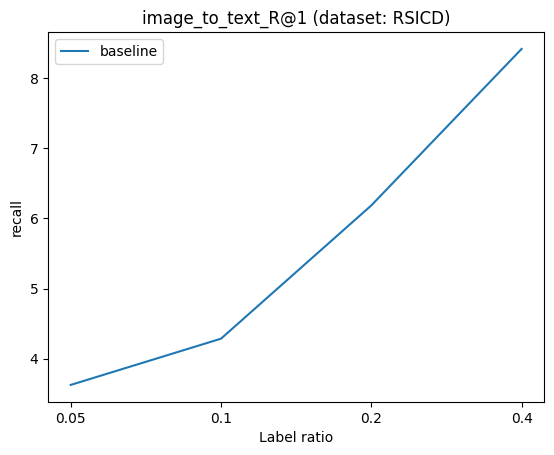

In [17]:
plot_model_comparison(results_dict, 'image_to_text_R@1', 'RSICD')